> ### Kaggle Challenge link : [here](https://www.kaggle.com/c/padhai-hindi-vowel-consonant-classification/overview)

### Downloading the data
- Install kaggle api and run upload your json cred on colab, then run the below cells

In [0]:
# !rm /root/.kaggle
# !mkdir /root/.kaggle
# !cp kaggle.json /root/.kaggle
# !ls /root/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions download -c padhai-hindi-vowel-consonant-classification -p {'./data'}

In [0]:
# !unzip "./data/*.zip" -d ./data

In [0]:
# delete the zip's
# !rm ./data/*.zip

In [0]:
root_path = "./HINDI_VOWEL_CONSONANT/"

In [5]:
!dir "./HINDI_VOWEL_CONSONANT/"

 Volume in drive F is ML-SSD
 Volume Serial Number is 74D1-A10C

 Directory of F:\HINDI_VOWEL_CONSONANT

03/31/2020  10:17 PM    <DIR>          .
03/31/2020  10:17 PM    <DIR>          ..
03/30/2020  05:33 PM    <DIR>          .ipynb_checkpoints
03/31/2020  09:55 PM    <DIR>          data
03/31/2020  11:44 PM    <DIR>          Models
03/31/2020  12:08 AM            29,838 PyTorch_Data_Loader_Code_for_Vowel_Consonant_Classification.ipynb
12/03/2019  02:21 PM           148,908 sample_submission.csv
03/31/2020  10:20 PM    <DIR>          Submission_folder
12/03/2019  02:21 PM        95,729,927 test.zip
12/03/2019  02:22 PM        95,737,058 train.zip
               4 File(s)    191,645,731 bytes
               6 Dir(s)  236,768,710,656 bytes free


* We have train.zip, test.zip and sample_submission.csv, we have some code to load data i.e in ipnyb file, but we will create our own dataset class.
* Let's extract the zip's to the same folder and delete the zips

### Data loading

* as we can see labels are in the image name itself like V6_C6_73.png means this image is 6 th vowel, 6th consonant and 73 rd image in the dataset

In [0]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import albumentations
from torchvision import transforms, utils,models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import glob
from PIL import Image
import PIL
import matplotlib.image as mpimg
import copy
import pretrainedmodels

In [7]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [0]:
# let's create csv's which will contain the labels of train ,test and validation

def remove_extra_info(name):
    if '.png' in name:
        return name.split('.')[0].strip()
    else:
        print(name)
        raise Exception('Not an image')

def create_label_csv_from_image_names(path_to_image_folder,TEST = False):
    file_names = os.listdir(path_to_image_folder)
    file_names = list(map(remove_extra_info,file_names))
    
    df = pd.DataFrame(data = file_names,columns = ['image'])

    if TEST:
        return df
    else:
        df['vowel'] = df['image'].apply(lambda x : int(x.split('_')[0].split('V')[-1]))
        df['consonant'] = df['image'].apply(lambda x : int(x.split('_')[1].split('C')[-1]))
        
        return df


In [0]:
df_train_annotation = create_label_csv_from_image_names(root_path+'./data/train')

In [10]:
df_train_annotation.sample(10)

,image,vowel,consonant
9944,V9_C9_49,9,9
4339,V4_C3_44,4,3
6886,V6_C8_87,6,8
6286,V6_C2_87,6,2
5711,V5_C7_19,5,7
3912,V3_C9_2,3,9
2745,V2_C7_5,2,7
1844,V1_C8_49,1,8
977,V0_C9_79,0,9
2898,V2_C8_98,2,8


In [11]:
df_train_annotation.iloc[101].values[1:]

array([0, 1], dtype=object)

In [12]:
# we also have to create a validation set

# we will pick randomly 20 % of the data from this dataFrame and save them to another df

df_validation = df_train_annotation.sample((df_train_annotation.shape[0] * 20) // 100)

# drop  those rows from the train df
df_train_annotation = df_train_annotation.drop(df_validation.index)

print(f'Train set len : {df_train_annotation.shape[0]}')
print(f'Validation set len : {df_validation.shape[0]}')

Train set len : 8000
Validation set len : 2000


In [0]:
df_train_annotation.to_csv(root_path+'./data/train_annotation.csv',index = False)
df_validation.to_csv(root_path+'./data/valid_annotation.csv',index = False)

* Now Let's write our dataset class

In [0]:
## Don't load the images in the __init__ , load it inside __getitem__ , memory efficient 

class HindiVowelConsonantTrainDataset(Dataset):
    """ Hindi Vowel Consonant Train Dataset """

    def __init__(self,csv_file,root_dir,transform):
        """
        Args : 
        csv_file : annotation file
        root_dir : image dir
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_name = os.path.join(self.root_dir,self.labels.iloc[index,0])
        image = None
        f = open(image_name+'.png', 'rb')
        image = Image.open(f)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels.iloc[index].values[1:].astype(np.long)
        label= torch.tensor(label,dtype = torch.long)

        return image,label

In [0]:
transform_train = transforms.Compose([
    transforms.ColorJitter(),
    transforms.Resize(128),
    transforms.ToTensor(),
    ])

In [0]:
trainset = HindiVowelConsonantTrainDataset(root_path+'./data/train_annotation.csv',root_path+'./data/train',transform=transform_train)

valset = HindiVowelConsonantTrainDataset(root_path+'./data/valid_annotation.csv',root_path+'./data/train',transform=transform_train)

In [17]:
print(f'Train_set size = {len(trainset)}')
print(f'Val_set size = {len(valset)}')

Train_set size = 8000
Val_set size = 2000


In [0]:
def imshow(image,label):
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
    plt.imshow(image)
    plt.title(label)
    plt.show()

torch.Size([4, 3, 128, 128])
torch.Size([4, 2])
tensor([3, 9])


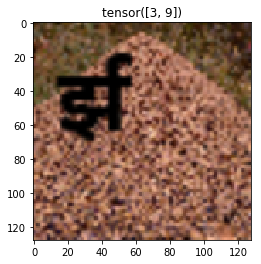

In [19]:
# plot some samples

trainloader = DataLoader(trainset,batch_size = 4,shuffle = True)

i = iter(trainloader)

images,labels = i.next()

print(images.shape)
print(labels.shape)
print(labels[3])

imshow(images[3],labels[3])

In [20]:
labels

tensor([[8, 8],
        [5, 3],
        [1, 7],
        [3, 9]])

In [21]:
labels[:,1]

tensor([8, 3, 7, 9])

### Modeling

In [0]:
# Let's write Model class

class Model_ResNet_34(nn.Module):

    def __init__(self,use_pretrained = False):
        super(Model_ResNet_34,self).__init__()

        if use_pretrained:
            self.base_model_arc  = pretrainedmodels.__dict__['resnet34'](pretrained = "imagenet")
        else:
            self.base_model_arc = pretrainedmodels.__dict__['resnet34'](pretrained = None)

        
        self.fc_1 = nn.Linear(512,10,bias = True)
        torch.nn.init.xavier_uniform_(self.fc_1.weight)
        torch.nn.init.zeros_(self.fc_1.bias)

        self.fc_2 = nn.Linear(512,10,bias = True)
        torch.nn.init.xavier_uniform_(self.fc_2.weight)
        torch.nn.init.zeros_(self.fc_2.bias)

        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self,x):
        bs ,_,_,_ = x.shape
        x = self.base_model_arc.features(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
        fc_1 = self.softmax(self.fc_1(x))
        fc_2 = self.softmax(self.fc_2(x))

        return fc_1,fc_2

In [0]:
# Let's write Model class

class Model_ResNet_50(nn.Module):

    def __init__(self,use_pretrained = False):
        super(Model_ResNet_50,self).__init__()

        if use_pretrained:
            self.base_model_arc  = pretrainedmodels.__dict__['resnet50'](pretrained = "imagenet")
        else:
            self.base_model_arc = pretrainedmodels.__dict__['resnet50'](pretrained = None)

        
        self.fc_1 = nn.Linear(512,10,bias = True)
        torch.nn.init.xavier_uniform_(self.fc_1.weight)
        torch.nn.init.zeros_(self.fc_1.bias)

        self.fc_2 = nn.Linear(512,10,bias = True)
        torch.nn.init.xavier_uniform_(self.fc_2.weight)
        torch.nn.init.zeros_(self.fc_2.bias)

        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self,x):
        bs ,_,_,_ = x.shape
        x = self.base_model_arc.features(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
        fc_1 = self.softmax(self.fc_1(x))
        fc_2 = self.softmax(self.fc_2(x))

        return fc_1,fc_2

In [0]:
class Model_Mobilnet(nn.Module):
    def __init__(self,use_pretrained = False,freeze_param = True):
        super(Model_Mobilnet,self).__init__()

        if use_pretrained:
            self.base_model_arc  = models.mobilenet_v2(pretrained = True)
        else:
            self.base_model_arc = models.mobilenet_v2()
        
        if freeze_param and use_pretrained:
            for param in self.base_model_arc.parameters():
                param.requires_grad = False
        
        self.base_model_arc.classifier = nn.Sequential(nn.Dropout(p=0.2))
        self.fc_1 = nn.Linear(1280, 10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc_1.weight)
        torch.nn.init.zeros_(self.fc_1.bias)
        self.fc_2 = nn.Linear(1280, 10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc_2.weight)
        torch.nn.init.zeros_(self.fc_2.bias)

        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self,x):
        bs ,_,_,_ = x.shape
        x = self.base_model_arc(x)
        # x = x.reshape(bs,-1)
        fc_1 = self.softmax(self.fc_1(x))
        fc_2 = self.softmax(self.fc_2(x))

        return fc_1,fc_2

In [0]:
MODEL_ZOO = {
    'resnet_34':Model_ResNet_34,
    'resent_50':Model_ResNet_50,
    'mobilnet':Model_Mobilnet
}

In [0]:
resnet_34 = MODEL_ZOO['resnet_34'](use_pretrained = True)

In [0]:
mobilnet = MODEL_ZOO['mobilnet'](use_pretrained=True)

In [0]:
resnet_50 = MODEL_ZOO['resent_50'](use_pretrained=True)

In [29]:
# Test the model with sample batch i.e 4 images batch we created above, to see of the output we get is the expected one or not

out = resnet_34(images)

op_1,op_2 = out

print(op_1.shape,op_2.shape)
print(op_1)

torch.Size([4, 10]) torch.Size([4, 10])
tensor([[-4.8650, -6.2947, -3.0144, -4.3764, -3.8617, -1.0676, -1.9164, -1.9581,
         -3.6852, -1.3839],
        [-8.8384, -6.8907, -7.1143, -5.2189, -7.6772, -5.7572, -2.0856, -0.1512,
         -5.4726, -7.0469],
        [-4.5092, -5.6207, -2.9479, -1.8960, -5.3805, -2.8974, -3.2246, -0.5612,
         -2.5259, -3.4202],
        [-2.9534, -4.0987, -2.6144, -3.9306, -2.9990, -3.0090, -1.8966, -2.9347,
         -1.3012, -1.3326]], grad_fn=<LogSoftmaxBackward>)


In [0]:
def loss_fn(outputs,targets,criterion):
    op_1,op_2 = outputs
    t_1, t_2 = targets[:,0],targets[:,1]

    l_1 = criterion(op_1,t_1)
    l_2 = criterion(op_2,t_2)

    return (l_1 + l_2)

def train(dataloader, dataset, model, opt,device,criterion):
    model.train()
    model = model.to(device)
    print('Running traning loop..')
    for batch_index,data  in tqdm(enumerate(dataloader), total = len(dataset) // dataloader.batch_size):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs,labels,criterion)

        loss.backward()
        opt.step()

        del inputs, labels, outputs # to reduce memory usage in the GPU.
        torch.cuda.empty_cache()


def eval(dataloader, dataset, model,DEVICE,criterion):
    model = model.to(DEVICE)
    model.eval()
    final_loss = 0
    counter = 0
    print('Running evaluation loop..')
    for batch_index,data  in tqdm(enumerate(dataloader), total = len(dataset) // dataloader.batch_size):
        inputs,labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model(inputs)

        loss = loss_fn(outputs,labels,criterion)

        counter += 1

        final_loss += loss.item() # if we don't do .item() here, you will run out of GPU memory as all the loss will be 
                                  # accumulated on the gpu, .item() will transfer them to cpu i.e store it on RAM
        del inputs, labels, outputs # to reduce memory usage in the GPU.
        torch.cuda.empty_cache()
    return final_loss / counter 


def accuracy(dataloader,model,device):
    total, correct = 0, 0
    model.to(device)
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        label_vowel = labels[:,0]
        label_cons = labels[:,1]

        op_vowel, op_cons = model(inputs)

        _, pred_vowel = op_vowel.topk(1)
        _, pred_cons = op_cons.topk(1)

        pred_vowel = pred_vowel.view(-1)
        pred_cons = pred_cons.view(-1)
        total += labels.size(0)

        correct += ((pred_vowel == label_vowel) & (pred_cons == label_cons)).sum().item()

    return 100 * correct / total

In [0]:
def learn(epochs,train_set,val_set,lr,optimizer,train_loader,val_loader,criterion,model,model_name):
    Best_Model = None
    loss_dict = dict()
    for e in range(epochs):
        print(f'Current epoch no : {e+1}/{epochs}')
        train(train_loader,train_set,model,optimizer,device,criterion)

        print(f'Train acc : {accuracy(train_loader,model,device)}')
        print(f'Val acc : {accuracy(val_loader,model,device)}')
        
        if os.path.isdir(root_path+'./Models') == False:
            os.mkdir(root_path+'./Models')
        
        torch.save(model.state_dict(),f'{root_path}/Models/{model_name}_epoch_{e}.pth')
        
        val_score = eval(val_loader,val_set,model,device,criterion)

        if len(list(loss_dict.keys())) != 0:
            if val_score < list(loss_dict.values())[-1]:
                Best_Model = copy.deepcopy(model.state_dict())
                print(f"model checkpointed at loss = {val_score}")

        loss_dict[e] = val_score

        print(f'Validation loss : {val_score}')
        print("#"*100)
        print()

    plt.plot(list(loss_dict.keys()),list(loss_dict.values()))
    plt.xlabel("epochs")
    plt.ylabel("val-loss")
    plt.show()
    return Best_Model 


In [0]:
torch.cuda.empty_cache()

In [0]:
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 256
lr = 0.001
epochs = 25
train_loader = DataLoader(trainset,batch_size = BATCH_SIZE_TRAIN,shuffle=True)

val_loader = DataLoader(valset,batch_size = BATCH_SIZE_VAL,shuffle=True)

m_reset_34 = MODEL_ZOO['resnet_34'](use_pretrained = True)

optimizer_resenet_34 = torch.optim.Adam(m_reset_34.parameters(),lr = lr)

criterion = nn.NLLLoss()

Current epoch no : 1/20
Running traning loop..



Train acc : 48.975
Val acc : 48.05
Running evaluation loop..



Validation loss : 1.747955471277237
####################################################################################################

Current epoch no : 2/20
Running traning loop..



Train acc : 68.8125
Val acc : 64.0
Running evaluation loop..



model checkpointed at loss = 1.0671765580773354
Validation loss : 1.0671765580773354
####################################################################################################

Current epoch no : 3/20
Running traning loop..



Train acc : 74.575
Val acc : 67.5
Running evaluation loop..



model checkpointed at loss = 0.9506021663546562
Validation loss : 0.9506021663546562
####################################################################################################

Current epoch no : 4/20
Running traning loop..



Train acc : 78.225
Val acc : 70.35
Running evaluation loop..



model checkpointed at loss = 0.8488302007317543
Validation loss : 0.8488302007317543
####################################################################################################

Current epoch no : 5/20
Running traning loop..



Train acc : 81.1625
Val acc : 72.2
Running evaluation loop..



model checkpointed at loss = 0.8424148857593536
Validation loss : 0.8424148857593536
####################################################################################################

Current epoch no : 6/20
Running traning loop..



Train acc : 83.925
Val acc : 74.0
Running evaluation loop..



model checkpointed at loss = 0.7864804565906525
Validation loss : 0.7864804565906525
####################################################################################################

Current epoch no : 7/20
Running traning loop..



Train acc : 86.5
Val acc : 75.3
Running evaluation loop..



model checkpointed at loss = 0.7841833531856537
Validation loss : 0.7841833531856537
####################################################################################################

Current epoch no : 8/20
Running traning loop..



Train acc : 88.6375
Val acc : 75.25
Running evaluation loop..



Validation loss : 0.7946861609816551
####################################################################################################

Current epoch no : 9/20
Running traning loop..



Train acc : 88.975
Val acc : 76.2
Running evaluation loop..



Validation loss : 0.7966488972306252
####################################################################################################

Current epoch no : 10/20
Running traning loop..



Train acc : 89.4875
Val acc : 76.0
Running evaluation loop..



Validation loss : 0.8198287487030029
####################################################################################################

Current epoch no : 11/20
Running traning loop..



Train acc : 90.0625
Val acc : 75.8
Running evaluation loop..



Validation loss : 0.8369582369923592
####################################################################################################

Current epoch no : 12/20
Running traning loop..



Train acc : 92.5375
Val acc : 77.1
Running evaluation loop..



Validation loss : 0.8582431524991989
####################################################################################################

Current epoch no : 13/20
Running traning loop..



Train acc : 92.5875
Val acc : 76.15
Running evaluation loop..



Validation loss : 0.9054598659276962
####################################################################################################

Current epoch no : 14/20
Running traning loop..



Train acc : 94.9125
Val acc : 77.95
Running evaluation loop..



Validation loss : 0.9296093955636024
####################################################################################################

Current epoch no : 15/20
Running traning loop..



Train acc : 95.575
Val acc : 77.15
Running evaluation loop..



Validation loss : 0.9712299332022667
####################################################################################################

Current epoch no : 16/20
Running traning loop..



Train acc : 94.7
Val acc : 75.55
Running evaluation loop..



Validation loss : 1.032988280057907
####################################################################################################

Current epoch no : 17/20
Running traning loop..



Train acc : 95.575
Val acc : 78.25
Running evaluation loop..



model checkpointed at loss = 0.9491860270500183
Validation loss : 0.9491860270500183
####################################################################################################

Current epoch no : 18/20
Running traning loop..



Train acc : 95.325
Val acc : 76.4
Running evaluation loop..



Validation loss : 1.0241968035697937
####################################################################################################

Current epoch no : 19/20
Running traning loop..



Train acc : 96.125
Val acc : 76.25
Running evaluation loop..



Validation loss : 1.1217954978346825
####################################################################################################

Current epoch no : 20/20
Running traning loop..



Train acc : 95.8
Val acc : 76.85
Running evaluation loop..



model checkpointed at loss = 1.0860373079776764
Validation loss : 1.0860373079776764
####################################################################################################



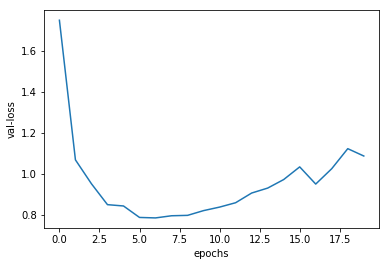

In [145]:
# resnet_34 traning 
best_model  = learn(epochs = epochs,train_set = trainset,val_set = valset,lr = lr,optimizer = optimizer_resenet_34,
                    train_loader = train_loader,val_loader = val_loader,criterion = criterion,model=m_reset_34,model_name="resent_34")

### Creating the submission file

In [169]:
# Creating test images annotation file

df_test = create_label_csv_from_image_names(root_path+'./data/test',TEST = True)
df_test.head()

,image
0,1
1,10
2,100
3,1000
4,10000


In [0]:
df_test.to_csv(root_path+'./data/test_annotation.csv',index = False)

In [0]:
## Don't load the images in the __init__ , load it inside __getitem__ , memory efficient 

class HindiVowelConsonantTestDataset(Dataset):
    """ Hindi Vowel Consonant Train Dataset """

    def __init__(self,csv_file,root_dir,transform):
        """
        Args : 
        csv_file : annotation file
        root_dir : image dir
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_name = os.path.join(self.root_dir,str(self.labels.iloc[index,0]))
        image = None
        f = open(image_name+'.png', 'rb')
        image = Image.open(f)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels.iloc[index].values[0]

        return {
            "image":image,
            "image_id":label
        }

In [0]:
transform_test = transforms.Compose([
    transforms.ColorJitter(),
    transforms.Resize(128),
    transforms.ToTensor(),
    ])

In [0]:
testset = HindiVowelConsonantTestDataset(root_path+'./data/test_annotation.csv',root_path+'./data/test',transform=transform_test)

In [193]:
len(testset)

10000

In [0]:
testloader = DataLoader(testset,batch_size = 128)

In [0]:
def create_submission_file_df(model,testloader,total):
    predictions = []
    model.to(device)
    model.eval()

    for batch_index,data  in enumerate(testloader):
        inputs,img_ids = data['image'],data['image_id']
        
        inputs = inputs.to(device)
        op_vowel,op_cons = model(inputs)
        
        _, pred_vowel = op_vowel.topk(1)
        _, pred_cons = op_cons.topk(1)

        for ii,im_id in enumerate(img_ids):
            predictions.append((f"{im_id}.png",f"V{pred_vowel[ii].item()}_C{pred_cons[ii].item()}"))
            
    
    df = pd.DataFrame(data = predictions,columns = ['ImageId','Class'])

    return df
        

In [208]:
# let's load the pre-trained model 

model = MODEL_ZOO['resnet_34'](use_pretrained = False)

model.load_state_dict(torch.load(root_path+'/Models/best_model_resnet_34.pth'))

<All keys matched successfully>

In [0]:
df_sub = create_submission_file_df(model,testloader,total = len(testset))

In [213]:
df_sub.head()

,ImageId,Class
0,1.png,V0_C0
1,10.png,V0_C0
2,100.png,V0_C0
3,1000.png,V0_C9
4,10000.png,V9_C9


In [0]:
df_sub.to_csv(root_path+"./Submission_folder/first_try.csv",index=False)